In [1]:
from sqlalchemy import create_engine
import pandas as pd
import json
from tqdm.notebook import tqdm
import csv
from rdkit.Chem import AllChem as rdkit
import fnmatch
from collections import defaultdict
from ast import literal_eval
from pathlib import Path
import os
import seaborn as sns
from matplotlib import pyplot as plt
import itertools as it
from typing import List

In [ ]:
def get_path():
    contains = ["SAScore", "SCScore", "RFModel"]
    fgs = ["Amine", "Aldehyde"]
    for dirpath, dirname, filename in os.walk("."):
        if (
            len(dirpath.split("/")) == 5
            and any(c in dirpath for c in contains)
            and any(fg in dirpath for fg in fgs)
        ):
            yield dirpath

In [ ]:
# For writing molecules to their respective folders.
for path in get_path():
    path = Path(path)
    print(path)
    model_name = path.parents[1].stem.lower()
    dict_ascending = {
        "Lowest": True,
        "Highest": False,
    }
    dict_func_groups = {
        "Amine": "primary amine",
        "Aldehyde": "aldehyde",
    }
    func_group = dict_func_groups[path.stem]
    # Highest and lowest selection.
    if "Highest" in str(path) or "Lowest" in str(path):
        ascending = dict_ascending[path.parents[0].stem]
        with open(str(path.joinpath("Scores.csv")), "w") as f:
            csv_writer = csv.writer(f)
            csv_writer.writerow(df_unique_reaxys.columns)
            for i in range(10):
                column = (
                    df_unique_reaxys[df_unique_reaxys["func_group"] == func_group]
                    .sort_values(model_name, ascending=ascending)
                    .iloc[i]
                )
                smiles = column["smiles"]
                mol = rdkit.MolFromSmiles(smiles)
                rdkit.EmbedMolecule(mol)
                rdkit.MolToMolFile(mol, str(path.joinpath(f"{i}.mol")))
                csv_writer.writerow(column.to_list())
    # Median value selection.
    elif "Medium" in str(path):
        with open(str(path.joinpath("Scores.csv")), "w") as f:
            csv_writer = csv.writer(f)
            csv_writer.writerow(df_unique_reaxys.columns)
            df_funcgroup = (
                df_unique_reaxys[df_unique_reaxys["func_group"] == func_group]
            )
            df_median = df_funcgroup[df_funcgroup[model_name] == df_funcgroup[model_name].median()].sort_values(model_name)
            df_above_median = df_funcgroup[df_funcgroup[model_name] > df_funcgroup[model_name].median()].sort_values(model_name)[0:4]
            df_below_median = df_funcgroup[df_funcgroup[model_name] < df_funcgroup[model_name].median()].sort_values(model_name, ascending=False)[0:4]
            df_combined = pd.concat([df_above_median, df_below_median, df_median])
            for i in range(len(df_combined)):
                column = df_combined.iloc[i]
                smiles = column["smiles"]
                mol = rdkit.MolFromSmiles(smiles)
                rdkit.EmbedMolecule(mol)
                rdkit.MolToMolFile(mol, str(path.joinpath(f"{i}.mol")))
                csv_writer.writerow(column.to_list())

In [4]:
con = create_engine(
    "sqlite:///Data/Testing_Data/Reaxys_DB_Scored_AddHs.db"
)
df_reaxys = pd.read_sql(sql="synthetic_accesibility", con=con)

In [ ]:
con = create_engine(
    "sqlite:///Data/Testing_Data/Molder_DB_SA_AddHs.db"
)
df_training = pd.read_sql(sql='synthetic_accesibility', con=con)

In [ ]:
df_unique_reaxys = df_reaxys[~df_reaxys['smiles'].isin(df_training['smiles'])].drop_duplicates('smiles')
df_nonunique_reaxys = df_reaxys[df_reaxys['smiles'].isin(df_training['smiles'])]

In [ ]:
# Databases on model trained with no Hs added in the fingerprints.
con = create_engine(
    "sqlite:///Data/Testing_Data/Reaxys_DB_Scored.db"
)
df_reaxys_nohs = pd.read_sql(sql="synthetic_accesibility", con=con)
con = create_engine(
    "sqlite:///Data/Testing_Data/Molder_DB_SA.db"
)
df_training_nohs = pd.read_sql(sql='synthetic_accesibility', con=con)
df_unique_reaxys_nohs = df_reaxys_nohs[~df_reaxys_nohs['smiles'].isin(df_training_nohs['smiles'])]

In [ ]:
fig, ax = plt.subplots()
sns.distplot(ax=ax, a=df_reaxys["sascore"], label="SAScore", kde=True, hist=False)
sns.distplot(ax=ax, a=df_reaxys["scscore"], label="SCScore", kde=True, hist=False)
sns.distplot(ax=ax, a=df_reaxys["rfmodel"], label="RFModel", kde=True, hist=False)
sns.despine()
ax.set_ylabel("Probability Density")
ax.set_xlabel("Synthetic Difficulty for Molecules in Reaxys Database / no units")

In [ ]:
fig, ax = plt.subplots()
sns.distplot(ax=ax, a=df_reaxys_nohs["sascore"], label="SAScore", kde=True, hist=False)
sns.distplot(ax=ax, a=df_reaxys_nohs["scscore"], label="SCScore", kde=True, hist=False)
sns.distplot(ax=ax, a=df_reaxys_nohs["rfmodel"], label="RFModel", kde=True, hist=False)
sns.despine()
ax.set_ylabel("Probability Density")
ax.set_xlabel("Synthetic Difficulty for Molecules in Reaxys Database (no Hs) / no units")

In [ ]:
fig, ax = plt.subplots()
sns.distplot(ax=ax, a=df_unique_reaxys["sascore"], label="SAScore", kde=True, hist=False)
sns.distplot(ax=ax, a=df_unique_reaxys["scscore"], label="SCScore", kde=True, hist=False)
sns.distplot(ax=ax, a=df_unique_reaxys["rfmodel"], label="RFModel", kde=True, hist=False)
sns.despine()
ax.set_ylabel("Probability Density")
ax.set_xlabel("Synthetic Difficulty for Unique Molecules / no units")

In [ ]:
fig, ax = plt.subplots()
sns.distplot(ax=ax, a=df_unique_reaxys_nohs["sascore"], label="SAScore", kde=True, hist=False)
sns.distplot(ax=ax, a=df_unique_reaxys_nohs["scscore"], label="SCScore", kde=True, hist=False)
sns.distplot(ax=ax, a=df_unique_reaxys_nohs["rfmodel"], label="RFModel", kde=True, hist=False)
sns.despine()
ax.set_ylabel("Probability Density")
ax.set_xlabel("Synthetic Difficulty for Unique Molecules (noHs) / no units")

In [ ]:
fig, ax = plt.subplots()
sns.distplot(ax=ax, a=df_training["sascore"], label="SAScore", kde=True, hist=False)
sns.distplot(ax=ax, a=df_training["scscore"], label="SCScore", kde=True, hist=False)
sns.distplot(ax=ax, a=df_training["rfmodel"], label="RFModel", kde=True, hist=False)
sns.despine()
ax.set_ylabel("Probability Density")
ax.set_xlabel("Synthetic Difficulty for Molecules in Training Set / no units")

In [ ]:
fig, ax = plt.subplots()
sns.distplot(ax=ax, a=df_training_nohs["sascore"], label="SAScore", kde=True, hist=False)
sns.distplot(ax=ax, a=df_training_nohs["scscore"], label="SCScore", kde=True, hist=False)
sns.distplot(ax=ax, a=df_training_nohs["rfmodel"], label="RFModel", kde=True, hist=False)
sns.despine()
ax.set_ylabel("Probability Density")
ax.set_xlabel("Synthetic Difficulty for Molecules in Training Set (noHs) / no units")

In [ ]:
# Testing for duplicates
db = Path.home()/"PhD/main_projects/synthetic_accessibility_project/stages/databases/reaxys_filtered_databases/all_precursors_filtered"
amines = list(db.glob("amine*/*.mol"))

In [ ]:
amines = [rdkit.MolFromMolFile(str(m), removeHs=False) for m in amines]

In [ ]:
amine_smiles = [rdkit.MolToSmiles(m) for m in amines]

In [ ]:
mol_file_to_smiles = lambda m: rdkit.MolToSmiles(rdkit.MolFromMolFile(m))
mol_file_to_smiles_addhs = lambda m: rdkit.MolToSmiles(
    rdkit.MolFromMolFile(m, removeHs=False)
)
mol_file_to_smiles_addhs_nonisomeric = lambda m: rdkit.MolToSmiles(
    rdkit.MolFromMolFile(m, removeHs=False), isomericSmiles=False
)

In [ ]:
dict_amines2f = defaultdict(list)
[dict_amines2f[mol_file_to_smiles(str(p))].append(p) for p in amines]
dict_amines2f_addhs = defaultdict(list)
[dict_amines2f_addhs[mol_file_to_smiles_addhs(str(p))].append(p) for p in amines]

In [ ]:
dupes = list(filter(lambda x: len(x[1]) > 1, dict_amines2f.items()))

In [ ]:
dupes_addhs = list(filter(lambda x: len(x[1]) > 1, dict_amines2f_addhs.items()))

In [ ]:
amines2 = [d for d in dupes if any('amines2f' in x.stem for x in d[1])]

In [ ]:
new = "/Users/stevenbennett/sshfs/stevenbennett@ch-sb2518.ch.ic.ac.uk/"
old = "/Users/stevenbennett/"

In [2]:
reaxys_full = Path(
    "/Users/stevenbennett/Desktop/ga_paper/clean"
)
reaxys_full_amines = list(reaxys_full.glob("amines2f/*.mol"))
reaxys_full_aldehydes = list(reaxys_full.glob("aldehydes3f/*.mol"))

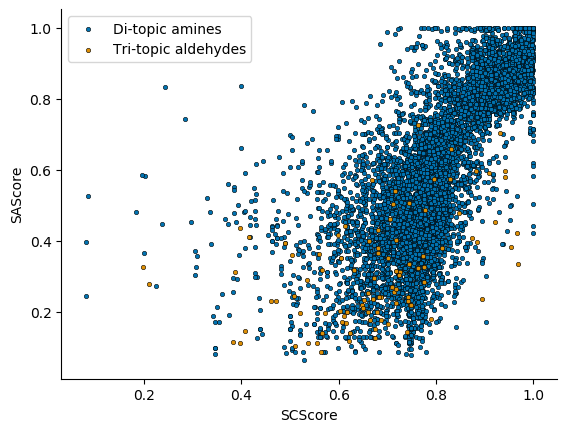

<Figure size 7680x5760 with 0 Axes>

In [134]:
# Plots the graph for Reaxys SA/SC scores.
palette = it.cycle(sns.color_palette('colorblind'))
fig, ax = plt.subplots()
sns.scatterplot(x=df_reaxys[df_reaxys['func_group'] == 'primary amine']['scscore'], y=df_reaxys[df_reaxys['func_group'] == 'primary amine']['sascore'], ax=ax, s=10, edgecolor='black', linewidth=0.4, color=next(palette), label='Di-topic amines')
sns.scatterplot(x=df_reaxys[df_reaxys['func_group'] == 'aldehyde']['scscore'], y=df_reaxys[df_reaxys['func_group'] == 'aldehyde']['sascore'], ax=ax, s=10, edgecolor='black', linewidth=0.4, color=next(palette), label='Tri-topic aldehydes')
ax.set_ylabel('SAScore')
ax.set_xlabel('SCScore')
sns.despine()
plt.figure(dpi=1200)
fig.savefig('Reaxys_DB_SA_SCScores.pdf')


In [ ]:
palette = it.cycle(sns.color_palette('colorblind'))
fig, ax = plt.subplots()
sns.scatterplot(x=df_reaxys[df_reaxys['rfmodel'] < 0.5]['scscore'], y=df_reaxys[df_reaxys['func_group'] == 'primary amine']['sascore'], ax=ax, s=10, edgecolor='black', linewidth=0.4, color=next(palette), label='Di-topic amines')
sns.scatterplot(x=df_reaxys[df_reaxys['rfmodel']['scscore'], y=df_reaxys[df_reaxys['func_group'] == 'aldehyde']['sascore'], ax=ax, s=10, edgecolor='black', linewidth=0.4, color=next(palette), label='Tri-topic aldehydes')
ax.set_ylabel('SAScore')
ax.set_xlabel('SCScore')
sns.despine()
plt.figure(dpi=1200)
fig.savefig('Reaxys_DB_SA_SCScores.pdf')

True

In [126]:
palette = sns.color_palette(sns.choose_colorbrewer_palette(data_type='sequential'))

interactive(children=(Dropdown(description='name', options=('Greys', 'Reds', 'Greens', 'Blues', 'Oranges', 'Pu…

In [101]:
df_reaxys.corr()

,sascore,scscore,rfmodel
sascore,1.000000,0.745473,0.538612
scscore,0.745473,1.000000,0.417148
rfmodel,0.538612,0.417148,1.000000
